In [1]:
# import libraries
import numpy as np
import matplotlib.image as mpimg # reading images to numpy arrays
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
import scipy.io as io

import warnings
warnings.filterwarnings('ignore')

In [2]:
## DO NOT RUN THIS CELL (DATA is stored later in .mat file - did not upload the original data)
img = mpimg.imread('Wifi_Image_dataset/1.jpg')
print(img.shape)
data = []
for i in map(str, range(1, 2401)):
    img = mpimg.imread('Wifi_Image_dataset/%s.jpg'%i)
    img = np.array(img)
#     img = normalize(img)
    data.append(img.reshape(-1,))

data = np.array(data)

print(data.shape)

(114, 122)
(2400, 13908)


In [4]:
# Manually create label data 
label = np.zeros(2400)
# '0' = 'sit', '1' = 'stand', '2' = 'walk'
label[200:400] = 1
label[400:600] = 2
label[800:1000] = 1
label[1000:1200] = 2
label[1400:1600] = 1
label[1600:1800] = 2
label[2000:2200] = 1
label[2200:2400] = 2

In [5]:
## DO NOT RUN THIS CELL (DATA is stored later in .mat file - did not upload the original data)
# Splitting the data and save it as a mat file
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42)
io.savemat('data.mat', {'data': data,
                        'X_train': X_train,
                        'y_train': y_train,
                        'X_test': X_test, 
                        'y_test': y_test
                       })


In [6]:
# Loading the data
data_load = io.loadmat('data.mat')
data = data_load['data']
X_train, X_test, y_train, y_test = data_load['X_train'], data_load['X_test'], data_load['y_train'], data_load['y_test']
y_train = y_train.reshape(-1,)

# Perform PCA on the data with 100 principal components
pca = PCA(n_components=100)
data_pca = pca.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data_pca, label, test_size=0.20, random_state=42)

(1920,)


In [7]:
# Using Lasso regression, work better with non-normalize data - 65% accuracy
regr = linear_model.Lasso(alpha=0.1)
regr.fit(X_train, y_train)
coeff = regr.coef_
y_pred = regr.predict(X_test)
y_pred[y_pred>1.5] = 2
y_pred[np.logical_and(y_pred>0.5, y_pred<1.5)] = 1
y_pred[y_pred<=0.5] = 0
accuracy_score(y_test, y_pred)

0.6395833333333333

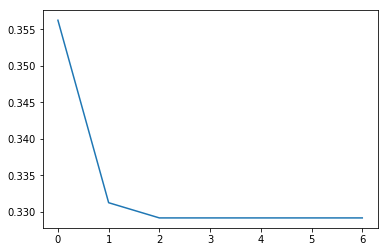

In [10]:
# Tuning alpha values 
alpha_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
accuracy_list = []
for i in alpha_list:
    clf = MLPClassifier(solver='sgd', alpha=i, learning_rate='adaptive', hidden_layer_sizes=(500, 800), random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_list.append(accuracy_score(y_test, y_pred))
plt.plot(range(len(alpha_list)), accuracy_list)

In [11]:
# Using KFold cross validation for finding the best hidden layer
kf = KFold(n_splits=5)
train_accuracies = []
val_accuracies = []
hidden = [(20, 50), (50, 100), (100, 300), (300, 500), (500, 800), (100, 50), (100, 300, 500)]
for hid in hidden:
    for train, val in kf.split(X_train):
        X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = X_train[train], X_train[val], y_train[train], y_train[val]
        clf = MLPClassifier(alpha=1e-3, hidden_layer_sizes=hid, random_state=1)
        clf.fit(X_train_tmp, y_train_tmp)
        y_pred = clf.predict(X_val_tmp)
        y_train_pred = clf.predict(X_train_tmp)
    
        train_accuracies.append(accuracy_score(y_train_tmp, y_train_pred))
        val_accuracies.append(accuracy_score(y_val_tmp, y_pred))
    print('Hidden layer: {}. Avg. training accuracy: {:4} %. Avg. validation accuracy: {:4} %.' .format(hid,round(np.mean(train_accuracies), 2), round(np.mean(val_accuracies), 2)))


Hidden layer: (20, 50). Avg. training accuracy:  1.0 %. Avg. validation accuracy: 0.86 %.
Hidden layer: (50, 100). Avg. training accuracy:  1.0 %. Avg. validation accuracy: 0.88 %.
Hidden layer: (100, 300). Avg. training accuracy:  1.0 %. Avg. validation accuracy:  0.9 %.
Hidden layer: (300, 500). Avg. training accuracy:  1.0 %. Avg. validation accuracy: 0.92 %.
Hidden layer: (500, 800). Avg. training accuracy:  1.0 %. Avg. validation accuracy: 0.93 %.
Hidden layer: (100, 50). Avg. training accuracy:  1.0 %. Avg. validation accuracy: 0.92 %.
Hidden layer: (100, 300, 500). Avg. training accuracy:  1.0 %. Avg. validation accuracy: 0.93 %.


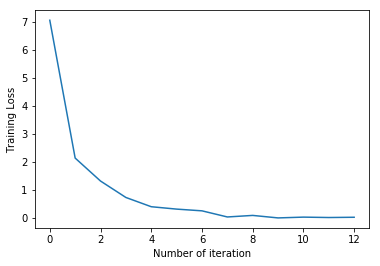

0.9729166666666667

<Figure size 432x288 with 0 Axes>

In [12]:
# Using the best hidden layers and plot the training loss
clf = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(500, 800), random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
loss_values = clf.loss_curve_
plt.plot(loss_values)
plt.xlabel('Number of iteration')
plt.ylabel('Training Loss')
plt.show()
plt.savefig('training_loss')
accuracy_score(y_test, y_pred)

In [13]:
# Per movement accuracy 
label_map = ['sit', 'stand', 'walk']
for id in range(len(label_map)):
    print('{}: {}'.format(label_map[id],sum([p and g for (p,g) in
       zip(np.array(y_pred)==np.array(y_test),np.array(y_test)==id)])/(sum(np.array(y_test)==id)+0.)))

sit: 0.9936708860759493
stand: 0.9819277108433735
walk: 0.9423076923076923


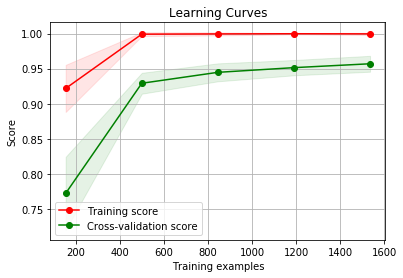

In [14]:
# Plot of the training/validation accuracy as a function of training samples
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Modified code from the link below (scikit-learn tutorial)
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPClassifier(alpha=1e-3, hidden_layer_sizes=(500, 800), random_state=1)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=4)

plt.show()

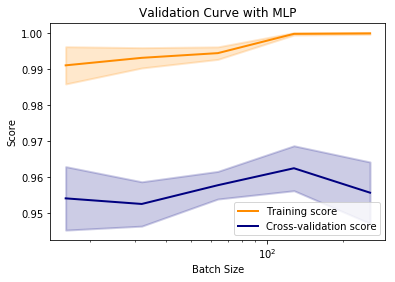

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot of the training/validation accuracy as a function of batch size

# Modified code from the link below (scikit-learn tutorial)
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

from sklearn.model_selection import validation_curve

param_range = [16, 32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    MLPClassifier(alpha=1e-3, hidden_layer_sizes=(500, 800), random_state=1), 
    X_train, y_train, param_name="batch_size", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with MLP")
plt.xlabel("Batch Size")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
plt.savefig('batch_size')

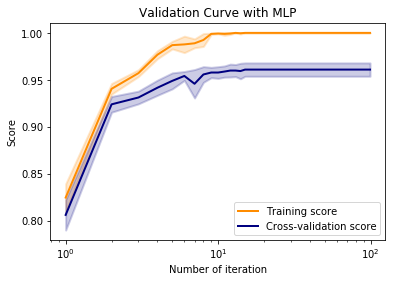

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot of the training/validation accuracy as a function of number of iterations
import warnings
warnings.filterwarnings('ignore')

# Modified code from the link below (scikit-learn tutorial)
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

param_range = range(1,100)
train_scores, test_scores = validation_curve(
    MLPClassifier(alpha=1e-3, hidden_layer_sizes=(500, 800), random_state=1), 
    X_train, y_train, param_name="max_iter", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with MLP")
plt.xlabel("Number of iteration")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()
plt.savefig('max_ier')